In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import warnings
from IPython import display
from keras import initializers
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization

warnings.simplefilter('ignore')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(29999, 128, 128, 3)


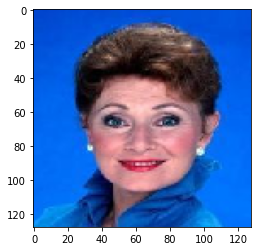

In [ ]:
#numpy array in .npy of 128X128 images with 3 RGB channels
train_images = np.load('/content/drive/My Drive/X_faces3c2_128.npy')
print(train_images.shape)
plt.imshow(train_images[5].reshape(128, 128, 3))

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 128, 128, 3).astype('float32')
#normalize images
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
img_shape = (128, 128, 3)
z_dim = 100
init = initializers.RandomNormal(mean=0.0, stddev=0.02)
opt2 = Adam(lr=0.0002, beta_1=0.5)

def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(256*8*8, input_shape=(100,), kernel_initializer=init))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 256)))
    
    model.add(layers.Conv2DTranspose(1024, (5, 5), strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(layers.LeakyReLU(alpha=0.2))
     
    model.add(layers.Conv2D(3, (5, 5), strides=1, padding='same', activation='tanh'))


    return model

In [ ]:
generator = make_generator_model()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 128, 128, 3)


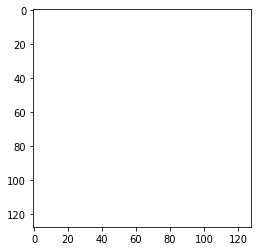

In [ ]:
#generate noise
noise = tf.random.normal([1, 100])
#generate image
generated_image = generator(noise, training=False)
#check dimensions of generated image
print(generated_image.shape)
shape = generated_image.shape[1:4]
#show image
plt.imshow(np.array(generated_image).reshape(shape) * 127.5 + 127.5)

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(Conv2D(64, (5, 5), strides=2, input_shape=img_shape, padding='same', kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(0.3))

    model.add(Conv2D(512, (5, 5), strides=1, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(0.3))

    model.add(Conv2D(1024, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(0.3))
    
    model.add(Conv2D(2048, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8, epsilon=0.00005))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
#make discriminator from scratch
discriminator = make_discriminator_model()

# restore weights of generator and discriminator from checkpoint for further training 
'''
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = '/content/drive/My Drive/training_1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.restore('/content/drive/My Drive/training_1/ckpt-54')
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
print(tf.train.latest_checkpoint(checkpoint_dir))
'''

#predict and print generated image using discriminator
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4999962]], shape=(1, 1), dtype=float32)


In [ ]:
# This returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#calculates discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
#calculates generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# produces evalution updates for training
def evaluate(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)
    print("Gen Loss")
    print(generator_loss(fake_output))
    print("disc Loss")
    print(discriminator_loss(real_output, fake_output))


In [ ]:
#initialiizes optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
#creates checkpoint object
checkpoint_dir = '/content/drive/My Drive/training_1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 125
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
''' 
The loss is calculated for each of these models, and the gradients are 
used to update the generator and discriminator.
'''

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      

    
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
# training procedure
def train(dataset, epochs):
  eo = 0
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      #produces evaluation updates for each epoch
      if eo != epoch:
        evaluate(image_batch)
      train_step(image_batch)
      eo = epoch

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      #save model in .h5 file
      generator.save('/content/drive/My Drive/1c_gen_simp_%03d.h5' % (epoch+1))
      #save checkpoint for training from this point
      checkpoint.save(file_prefix = checkpoint_prefix)
      

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      #print(predictions[i, :, :, 0].shape)
      plt.axis('off')

  plt.savefig('/content/drive/My Drive/image_at_epoch_simp{:04d}.png'.format(epoch))
  plt.show()


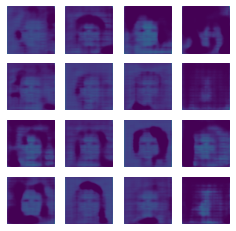

Time for epoch 33 is 528.4433097839355 sec
Gen Loss
tf.Tensor(0.14140601, shape=(), dtype=float32)
disc Loss
tf.Tensor(4.410438, shape=(), dtype=float32)


In [ ]:

train(train_dataset, EPOCHS)

NameError: ignored

<Figure size 288x288 with 0 Axes>